# Preamble

> This notebook contains the ground-truth copy of the code mixed with literate comments. All code in this directory is produced by running the cells in this notebook.

# Introduction

**Cortical visual prostheses** (CVPs) are devices implanted on the brain which aim to restore vision to blind people by stimulating the visual cortex.

Experiments have shown that stimulating the visual cortex produces visual percepts in both blind and sighted patients. These visual percepts are called **phosphenes** and are typically described as small round dots of colourless light like "a star in the sky." The idea behind most CVPs is to build images out of phosphenes, like how graphical displays are made out of pixels. 

But phosphenes are very limited. At the moment, we can only control the intensity of phosphenes (and, to some extent, their size). The locations of phosphenes follow the retinotopic mapping of the visual fields on the cortex, but the complexity of this mapping makes precisely controlling the positions of phosphenes in the visual field very difficult; it is much easier to instead place a regular grid of electrodes on the brain and map the phosphene locations after implantation. Other properties of phosphenes, such as their shape, individual brightness or colour, are highly variable and uncontrollable.

In addition, there are no empirical studies which describe what exactly is seen when we try to stimulate more than about five simultaneous phosphenes. The largest implant in a human used 64 electrodes, but there is inadequate description on what the implantee saw and how useful these percepts were (though the implantee purportedly was able to read large letterforms). New CVPs generally intend to stimulate on the order of hundreds of electrodes (such as 473 for the Monash Vision Group); it is not yet known what people will perceive when many electrodes are stimulate at once. Some studies have suggested that stimulating five electrodes, for example, does not produce five discrete phosphenes or a blended picture; rather, phosphenes which were stimulated by an electrode when only one electrode was stimulated completely disappear upon simultaneous stimulation as though they were not stimulated at all.

This begs the question: **how can phosphenes be used to convey useful information, given their known and unknown perceptual limitations?**

## Pattern-Based Approach

Using a pattern-based approach, we focus on **object identification**. That is, we attempt to create recognisable patterns that are matchable against object identities, and discard any location-based information.

The advantages of this approach are that:

1. By focusing on identity rather than location, stable patterns can be presented using the same phosphenes each time an object occurs in a scene. As the exact same pattern is presented each time, it may be easier to learn.

The disadvantages of this approach are that:

1. Only one object at a time can be shown.
2. If there is no location information, it may be hard to justify how this is useful in comparison to something less invasive; for example, an external camera linked to an earpiece could easily just speak out the identity of an object instead of presenting patterned vision. You could argue that presenting object identities through vision is beneficial because it doesn't take up another sensory modality, but this is a relatively small upside compared to the invasiveness of a brain implant.

## Location-Based Approach

Using a location-based approach, we focus on **object localisation**. 

## Rationale

# Phosphene Modelling

## Phosphene Rendering

In [770]:
%%writefile phosphenes.py
#!/usr/bin/env python

import numpy as np
import random
import tensorflow as tf
import keras
from math import e
from scipy.ndimage import gaussian_filter
from skimage import color
from abc import ABC, abstractmethod

def safebound(value: float, width: float, lower: float, upper: float):
    """ 
    Returns the bounded min and max about value with width.
    """
    vmin = int(max(lower, value - width / 2))
    vmax = int(min(upper, value + width / 2))
    return vmin, vmax

def bound(value:float, lower: float, upper:float):
    """
    Returns a bounded value.
    """
    if value > lower:
        if value < upper:
            return value
        return upper
    return lower

# Electrodes, which produce phosphenes.

class Electrode:
    """
    Produces a phosphene for a single electrode.
    """
    def __init__(self,
                 x: float,
                 y: float,
                 xsize: float,
                 ysize: float,
                 strength: float,
                 xdim: int,
                 ydim: int):
        """
        Args:
            x: float         - position in range [0, 1]. 
            y: float         - position in range [0, 1]
            xsize: int       - x size of the electrode (in units of output image)
            ysize: int       - y size of the electrode (in units of output image)
            strength: float  - relative brightness of the electrode in range [0, 1]
            xdim: int        - x dim of the output image
            ydim: int        - y dim of the output image 
        """
        self.x = x
        self.y = y
        self.xdim = xdim
        self.ydim = ydim
        self.xsize = xsize
        self.ysize = ysize
        self.strength = strength

        self.rendered = self.render()

    def render(self):
        xmin, xmax = safebound(self.xdim * self.x, self.xsize, 0, self.xdim)
        ymin, ymax = safebound(self.ydim * self.y, self.ysize, 0, self.ydim)

        base = np.zeros((self.ydim, self.xdim))
        base[ymin:ymax, xmin:xmax] = self.strength
        
        blurred = gaussian_filter(base, (self.xsize * self.ysize) ** 0.5, mode='constant')
        
        # Rescale up to 1
        if blurred.max() <= 0:
            return blurred
        else:
            return blurred / blurred.max()

class DistortedElectrode(Electrode):
    """
    This class introduced random distortions to the rendered phosphene.
    """
    def __init__(self,
                 x: float,
                 y: float,
                 xsize: float,
                 ysize: float,
                 xdim: int,
                 ydim: int):
        
        x = bound(self.randomise(x), 0, 1)
        y = bound(self.randomise(y), 0, 1)
        xsize = max(0, int(self.randomise(xsize)))
        ysize = max(0, int(self.randomise(ysize)))
        strength = random.random()
        
        Electrode.__init__(self, x, y, xsize, ysize, strength, xdim, ydim)
        
    def randomise(self, value):
        randomised = value * (1 + (random.random() - 1) / 10)
        return randomised

# Grids, which are composed of electrodes.

class Grid(ABC): 
    def __init__(self,
                 ndim1: int, 
                 ndim2: int, 
                 xdim: int, 
                 ydim: int):
        """
        Base class for a rendering grid.
        
        Args:
            ndim1: int - number of electrodes for dimension 1
            ndim2: int - number of electrodes for dimension 2
            xdim: int  - x dimension of output image
            ydim: int  - y dimension of output image
        """
        self.ndim1 = ndim1
        self.ndim2 = ndim2
        self.vector_size = ndim1 * ndim2
        self.xdim = xdim
        self.ydim = ydim
        
        self.grid = self.make_grid()
        self.prerendered = np.array([electrode.rendered for electrode in self.grid])
        self.prerendered_tensor = tf.convert_to_tensor(self.prerendered, dtype=tf.float32)
        
        super().__init__()
        
    @abstractmethod
    def make_grid(self):
        pass
    
    def render(self, values: np.ndarray):
        
        # Multiply the values with the renders and sum
        product = values.reshape(self.vector_size, 1, 1) * self.prerendered
        summed = sum(product)

        # Clip, then scale between -1 and 1
        scaled = np.clip(summed, 0, 1) * 2 - 1
        
        return scaled
    
    def render_tensor(self, tensor):
        
        # Preprocessing
        tiled = tf.tile(tensor, tf.constant([self.xdim]))
        reshaped = tf.reshape(tiled, (self.xdim, self.vector_size, 1))
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        
        # Multiply the values with the renders and sum
        product = transposed * self.prerendered_tensor
        summed = tf.reduce_sum(product, axis=0)
        
        # Clip, then scale by -1 and 1
        scaled = tf.clip_by_value(summed, 0, 1) * 2 - 1
        
        return scaled
        

class CartesianGrid(Grid):
    """
    A regular grid of electrodes with even spacing and even size. 
    """
    def __init__(self,
                 nxelectrode: int,
                 nyelectrode: int,
                 xdim: int,
                 ydim: int):
        """
        Args:
            nxelectrode: int - number of electrodes on x axis
            nyelectrode: int - number of electrodes on y axis
            xdim: int       - output x dimension of image
            ydim: int       - output y dimension of image
        """
        Grid.__init__(self, nxelectrode, nyelectrode, xdim, ydim)
        
    def make_grid(self):
        
        grid = [
            Electrode(x = x / self.ndim1,
                      y = y / self.ndim2,
                      xsize = np.sqrt(self.xdim // self.ndim1),
                      ysize = np.sqrt(self.ydim // self.ndim2),
                      strength = 1,
                      xdim = self.xdim,
                      ydim = self.ydim)
            for x in range(self.ndim1)
            for y in range(self.ndim2)
        ]
        
        return grid

class PolarGrid(Grid):
    """
    A polar regular grid of electrodes with even spacing 
    and size increasing with eccentricity. 
    """
    def __init__(self,
                 nradius: int,
                 ntheta: int,
                 xdim: int,
                 ydim: int):
        """
        Args:
            nradius: int - number of radii to place electrodes on
            ntheta: int  - number of angles to place electrodes on
            xdim: int    - output x dimension of image
            ydim: int    - output y dimension of image
        """
        Grid.__init__(self, nradius, ntheta, xdim, ydim)
        
    def iangle(self, i):
        """
        Calculates the angle for angle of index i in range(self.ndim2)
        """
        angle = (np.pi / (self.ndim2 - 1) * i) - (np.pi / 2)
        return angle
        
    def make_grid(self):
        
        k = self.xdim / 2 + self.ydim / 2
        a = e * (self.xdim + self.ydim) / 128
        
        xys = [
            (0.5 + (ir / self.ndim1 * np.cos(self.iangle(itheta))) / 2,
             0.5 + (ir / self.ndim1 * np.sin(self.iangle(itheta))) / 2,)
            for ir in range(1, self.ndim1 + 1)
            for itheta in range(self.ndim2)
        ]
        
        grid = [
            Electrode(x = x,
                      y = y,
                      xsize = np.log(k * ((x-0.5)**2 + (y-0.5)**2) + a),
                      ysize = np.log(k * ((x-0.5)**2 + (y-0.5)**2) + a),
                      strength = 1,
                      xdim = self.xdim,
                      ydim = self.ydim)
            for (x, y) in xys
        ]
        
        return grid
    
class DistortedPolarGrid(PolarGrid):
    """
    A polar grid with distorted electrodes.
    """
        
    def make_grid(self):
        
        k = self.xdim / 2 + self.ydim / 2
        a = e * (self.xdim + self.ydim) / 128
        
        xys = [
            (0.5 + (ir / self.ndim1 * np.cos(self.iangle(itheta))) / 2,
             0.5 + (ir / self.ndim1 * np.sin(self.iangle(itheta))) / 2,)
            for ir in range(1, self.ndim1 + 1)
            for itheta in range(self.ndim2)
        ]
        
        grid = [
            DistortedElectrode(x = x,
                               y = y,
                               xsize = np.log(k * ((x-0.5)**2 + (y-0.5)**2) + a),
                               ysize = np.log(k * ((x-0.5)**2 + (y-0.5)**2) + a),
                               xdim = self.xdim,
                               ydim = self.ydim)
            for (x, y) in xys
        ]
        
        return grid
    
class RescalingDistortedPolarGrid(DistortedPolarGrid):
    """
    A polar grid with distorted electrodes and non-summative rendering
    (rendering rescales the brightness to max). 
    """
    
    def render(self, values):
        
        # Multiply the values with the renders and sum
        product = values.reshape(self.vector_size, 1, 1) * self.prerendered
        summed = sum(product)
        summax = np.max(summed)

        # Rescale, then scale between -1 and 1
        scaled = (summed ** 2 / summax ** 2) * 2 - 1
        
        return scaled
    
    def render_tensor(self, tensor):
        
        # Preprocessing
        tiled = tf.tile(tensor, tf.constant([self.xdim]))
        reshaped = tf.reshape(tiled, (self.xdim, self.vector_size, 1))
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        
        # Multiply the values with the renders and sum
        product = transposed * self.prerendered_tensor
        summed = tf.reduce_sum(product, axis=0)
        summax = tf.reduce_max(summed)
        
        # Rescale, then scale between -1 and 1
        scaled = tf.divide(summed ** 2, summax ** 2) * 2 - 1
        
        return scaled      
        
# STIMULUS

class Stimulus:
    def __init__(self, image, grid, xpos=0, ypos=0):
        self.shape = image.shape
        
        if len(self.shape) == 2:
            self.original = image.reshape(*self.shape, 1)
            self.shape = self.original.shape
        else:
            self.original = image
            
        # Normalise between -1 and 1 for an RGB255 image
        self.original = (self.original / 127.5) - 1
        
        self.padder = np.zeros((3 * self.shape[0], 3 * self.shape[1], self.shape[2])) - 1
        self.padder[self.shape[0]:2*self.shape[0], self.shape[1]:2*self.shape[1], :] = self.original
        
        self.xpos = xpos
        self.ypos = ypos
        
        self.image = self.getImage()
        
        self.grid = grid
        self.sampleWidth = 6
        
        self.vector = self.process()
            
    def get_params(self, x : float, y : float):
        
        ymin = bound(int(self.shape[0] * y - self.sampleWidth // 2), 0, self.shape[0] - 1)
        ymax = bound(int(self.shape[0] * y + self.sampleWidth // 2), 0, self.shape[0] - 1)
        xmin = bound(int(self.shape[1] * x - self.sampleWidth // 2), 0, self.shape[1] - 1)            
        xmax = bound(int(self.shape[1] * x + self.sampleWidth // 2), 0, self.shape[1] - 1)

        vals  = self.image[ymin:ymax, xmin:xmax, :]
        return np.mean(vals)
    
    def getImage(self):
        """ Based on xpos and ypos, get the image view from the padder.
        """
        
        xstart = self.shape[0] - int(self.xpos * self.shape[0])
        ystart = self.shape[1] - int(self.ypos * self.shape[1])
        
        return self.padder[ystart:ystart+self.shape[1], xstart:xstart+self.shape[0], :]

    def process(self):
        """ Converts the stimulus into a brightness vector for the
        """

        params = np.array([self.get_params(e.x, e.y) for e in self.grid.grid])
        # Normalise to between 0 and 1
        params = params - (np.min(params))
        if np.max(params) > 0:
            params /= np.max(params)
        return params
    
    def setPos(self, xpos: float, ypos: float):
        """Translate the image. xpos and ypos lie in the range (-1, 1)
        """
        self.xpos = xpos
        self.ypos = ypos
        self.image = self.getImage()
        self.vector = self.process()

class StimulusNet(Stimulus):

    def __init__(self, image, grid, encoder_path):
        self.encoder = tf.keras.models.load_model(encoder_path)        
        Stimulus.__init__(self, image, grid)
    
    def process(self):
        image_tensor = tf.convert_to_tensor(np.array([self.image]), dtype=tf.float32)
        return self.encoder(image_tensor).numpy()[0]

Overwriting phosphenes.py


In [1]:
%run phosphenes.py

Using TensorFlow backend.


## Digit Experiment

In [772]:
%%writefile digits.py
#!/usr/bin/env python
"""
This script runs a digit recognition psychophysics session.
"""

# # Setup

import numpy as np
import json
import cv2
import pickle
from phosphenes import *
from datetime import datetime
from argparse import ArgumentParser
from psychopy import visual, core, gui, event
from box import Box
from psychopy.sound.backend_pygame import SoundPygame
from psychopy.tools.filetools import fromFile, toFile
from skimage import color
from imageio import imread
from random import random, choices
from PIL import Image

# I'm setting up a config dictionary with dot-syntax so it can be serialised 
# and saved with the session. I prefer explicitly keeping track of state.

config = Box({})

# Parsing the command line arguments, especially for testing.
parser = ArgumentParser(description='Digit recognition task.')

# Define command line arguments.
argspec = {
    'testing': {
        'action': 'store_const',
        'const': True,
        'default': False,
        'dest': 'testing',
        'help': 'Test the experiment and save the data.'
    },
    'ntrials': {
        'type': int,
        'nargs': '?',
        'default': 5,
        'help': 'Number of trials for the experiment.'
    },
    'ncues': {
        'type': int,
        'nargs': '?',
        'default': 10,
        'help': 'Number of cues per trial. Should be a multiple of 10 (for now) for digit stream.'
    },
    'grid': {
        'type': str,
        'nargs': '?',
        'default': 'polar',
        'help': 'The grid type for rendering. One of cartesian, polar, distortedPolar, or rescalingDistortedPolar, or a filepath to the grid to load.'
    },
    'processor': {
        'type': str,
        'nargs': '?',
        'default': 'direct',
        'help': 'The processor for the session. One of direct or net.'
    },
    'encoder': {
        'type': str,
        'nargs': '?',
        'default': None,
        'help': 'If the processor is a net, specify the filepath of the encoder to be used. '
    },
    'no-numpad': {
        'action': 'store_const',
        'const': True,
        'default': False,
        'dest': 'noNumpad',
        'help': 'Flags that normal number keys instead of numpad should be used.'
    },
    'with-scanning': {
        'action': 'store_const',
        'const': True,
        'default': False,
        'dest': 'withScanning',
        'help': 'Flags that scanning with the mouse should be enabled.'
    }
}

# Add arguments to the parser.
[parser.add_argument(f'--{k}', **v) for k, v in argspec.items()]

# Parse the arguments and save into config.
args = parser.parse_args()
config.TESTING        = args.testing
config.NTRIALS        = args.ntrials
config.NCUES          = args.ncues
config.GRID_TYPE      = args.grid
config.PROCESSOR_TYPE = args.processor
config.NO_NUMPAD      = args.noNumpad
config.ENCODER        = args.encoder
config.WITH_SCANNING  = args.withScanning


# First, we define the constants for the window size of the experiment.
# `XSIZE` and `YSIZE` refer to the size of the window on the screen.
# `EXSIZE` and `EYSIZE` refer to the size of the image data (i.e. how many 
# electrodes there are). 
# `SCALE` links the two. 

config.XSIZE  = 100
config.YSIZE  = 100
config.SCALE  = 10
config.EXSIZE = config.XSIZE // config.SCALE
config.EYSIZE = config.YSIZE // config.SCALE
config.INPUT_XSIZE = 64
config.INPUT_YSIZE = 64

# Next, we load the stimulus. Opening the image files can be expensive
# so we're doing at this at the very start and loading them into a 
# variable. 

# `IMAGE_TEMPLATE` is a string of the filepath of the stimulus digit images.
config.IMAGE_TEMPLATE = './data/digit-images-aliased/{}.png'

# `IMAGE_SIZE` is an (int, int) tuple of the image size of the first image.
# We assume that each image is of the same size as the image labelled "0"
config.IMAGE_SIZE = np.shape(imread(config.IMAGE_TEMPLATE.format(0)))  

# `IMAGE_SCALE` is an int describing the ratio of electrode size to image size.
# It assumes that EXSIZE == EYSIZE and the input images are square.
# This may need changing later. 
config.IMAGE_SCALE = config.EXSIZE / config.IMAGE_SIZE[0]  

# `IMAGES` holds the original digit images.
config.IMAGES = [cv2.cvtColor(cv2.resize(imread(config.IMAGE_TEMPLATE.format(digit)),
                                         dsize=(config.INPUT_XSIZE, config.INPUT_YSIZE)),
                              cv2.COLOR_RGBA2RGB)
                            for digit in range(10)]

# `STIMULI` contains a list of numpy arrays.
# Each element in the list holds the image data 
# for the digit equal to its index. Normalised to 
# between -1 and 1
config.STIMULI = [
    np.array(Image.fromarray(image).resize((config.EXSIZE, config.EYSIZE)))
    for image in config.IMAGES
]

# We initiate a grid of electrodes.
grids = {
    'cartesian': lambda: CartesianGrid(
        config.EXSIZE,
        config.EYSIZE, 
        config.XSIZE, 
        config.YSIZE
    ),
    'polar': lambda: PolarGrid(
        config.EXSIZE, 
        config.EYSIZE, 
        config.XSIZE, 
        config.YSIZE
    ),
    'distortedPolar': lambda: DistortedPolarGrid(
        config.EXSIZE,
        config.EYSIZE, 
        config.XSIZE, 
        config.YSIZE
    ),
    'rescalingDistortedPolar': lambda: RescalingDistortedPolarGrid(
        config.EXSIZE, 
        config.EYSIZE, 
        config.XSIZE, 
        config.YSIZE
    ),
}

try:
    grid = grids[config.GRID_TYPE]()
except KeyError:
    with open(config.GRID_TYPE, 'rb') as infile:
        grid = pickle.load(infile)

config.GRID = grid

# We initiate the stimulus processor type.

processors = {
    'direct': Stimulus,
    'net': lambda image, grid: StimulusNet(image, grid, config.ENCODER),
}

config.PROCESSOR = processors[config.PROCESSOR_TYPE]

# Templates for data paths.
config.DATETIME_FORMAT       = '%Y-%m-%d_%H-%M-%S'
config.DIGIT_SOUND_TEMPLATE  = './data/digit-voice/{}-alt.wav'

base_dir = './data/psychophysics-sessions/'

if config.TESTING:
    config.CONFIG_FILE_TEMPLATE  = base_dir + 'tests/{}_{}_config.json'
    config.SESSION_FILE_TEMPLATE = base_dir + 'tests/{}_{}_session.csv'
    config.MOUSE_FILE_TEMPLATE   = base_dir + 'tests/{}_{}_mouse.csv'
else:
    config.CONFIG_FILE_TEMPLATE  = base_dir + 'participants/{}_{}_config.json'
    config.SESSION_FILE_TEMPLATE = base_dir + 'participants/{}_{}_session.csv'
    config.MOUSE_FILE_TEMPLATE   = base_dir + 'participants/{}_{}_mouse.csv'

# Parameters for sound.
config.CORRECT_NOTE   = 'G'
config.INCORRECT_NOTE = 'Csh'
config.NOTE_DURATION  = 0.1
config.NOTE_VOLUME    = 0.5

# Session data.
config.SESSION_VARS = ['trial', 'cue', 'digit', 'keypress', 'cuetime', 'trialtime', 'sessiontime']
config.MOUSE_VARS   = ['trial', 'cue', 'digit', 'xmouse', 'ymouse', 'cuetime', 'trialtime', 'sessiontime']

# Output templates based on session data.
config.SESSION_HEADER       = ','.join(config.SESSION_VARS) + '\n'
config.SESSION_ROW_TEMPLATE = ','.join(['{' + word + '}' for word in config.SESSION_VARS]) + '\n'
config.MOUSE_HEADER         = ','.join(config.MOUSE_VARS) + '\n'
config.MOUSE_ROW_TEMPLATE   = ','.join(['{' + word + '}' for word in config.MOUSE_VARS]) + '\n'

# Mouse recording interval in seconds.
config.MOUSE_RECORD_INTERVAL = 0.2

# Text.
config.PROMPT_TEXT = "{}% complete.\n\nPress any key when ready."
config.END_TEXT    = "Thank you. \n\nPress any key to exit."

# If testing, the blank image.
if config.TESTING:
    config.BLANK_FILE = config.IMAGE_TEMPLATE.format('blank')
    config.BLANK_IMAGE = cv2.resize(np.flipud(imread(config.BLANK_FILE)), dsize=(config.INPUT_XSIZE, config.INPUT_YSIZE))
    config.TEST_WINDOW_XSIZE = 480
    config.TEST_WINDOW_YSIZE = 480

# Keypress during a trial.
if config.NO_NUMPAD:
    config.KEY_LIST=[str(x) for x in range(10)]
else:
    config.KEY_LIST = ["num_" + str(x) for x in range(10)]

# When saving the config, excluding some variables due to size.
config.EXCLUDED = ['STIMULI', 'GRID', 'IMAGES', 'BLANK_IMAGE', 'PROCESSOR']


# Here, we make our main experiment, only if called from the command line.
if __name__ == "__main__":
    
    # We initiate the user details and present a dialog to the user to get those details.
    config.details = {"datetime": datetime.strftime(datetime.now(), config.DATETIME_FORMAT), "participant": ""}
    dialog         = gui.DlgFromDict(config.details, title="PROTOTYPE", fixed=["datetime"])
    
    # We interpret the dialog actions and initiate data files if proceeding.
    if dialog.OK:
        config.configFile  = config.CONFIG_FILE_TEMPLATE.format(config.details["participant"], config.details["datetime"])
        config.sessionFile = config.SESSION_FILE_TEMPLATE.format(config.details["participant"], config.details["datetime"])
        config.mouseFile = config.MOUSE_FILE_TEMPLATE.format(config.details["participant"], config.details["datetime"])
    else:
        core.quit()

    # Clocks that keep track of the experiment.
    clockSession = core.Clock()
    clockTrial   = core.Clock()
    clockCue     = core.Clock()
    mouseRecord  = core.Clock()

    # We initiate some generic sounds for correct and incorrect.
    correctSound   = SoundPygame(value=config.CORRECT_NOTE, secs=config.NOTE_DURATION)
    incorrectSound = SoundPygame(value=config.INCORRECT_NOTE, secs=config.NOTE_DURATION)
    
    correctSound.setVolume(config.NOTE_VOLUME)
    incorrectSound.setVolume(config.NOTE_VOLUME)
    
    # And we initiate the sounds for each digit.
    digitSounds = [SoundPygame(value=config.DIGIT_SOUND_TEMPLATE.format(digit)) for digit in range(10)]
    
    # Now we save the config for this session.
    with open(config.configFile, 'w+') as configFile:
        json.dump({k:v for k, v in config.items() if k not in config.EXCLUDED}, configFile)

    # We initiate a testing window if this is a testing run.
    if config.TESTING:
        testWin = visual.Window([config.TEST_WINDOW_XSIZE, config.TEST_WINDOW_YSIZE],
                                pos=(200,200), allowGUI=False, winType='pyglet')
        win = visual.Window([config.TEST_WINDOW_XSIZE, config.TEST_WINDOW_YSIZE],
                            pos=(200+config.TEST_WINDOW_XSIZE, 200), allowGUI=False, winType='pyglet', color=-1)
    else:
        # We make a window for the experiment.
        win = visual.Window(fullscr=True, allowGUI=False, winType='pyglet', color=-1)

    # Start the mouse event
    mouse = event.Mouse(visible=False, win=win)
        
    # We now start the experiment loop.
    with open(config.sessionFile, 'w+') as outfile, open(config.mouseFile, 'w+') as mousefile:

        # We first write the header of the csv file.
        outfile.write(config.SESSION_HEADER)
        mousefile.write(config.MOUSE_HEADER)

        # Start the trial loop.
        for trial in range(config.NTRIALS):

            # Set the trial clock to 0.
            # This clock will start counting from the wait screen, so includes that time..
            clockTrial.reset()
            
            # If testing, show the blank.
            if config.TESTING:
                blankStimulus = config.PROCESSOR(config.BLANK_IMAGE, config.GRID)
                rendered = config.GRID.render(blankStimulus.vector)
                imageStimulus = visual.ImageStim(testWin, image=rendered, size=(2,2))
                imageStimulus.draw(); testWin.flip()

            # Show a prompt on grey background at the beginning of the trial and wait for a keypress.
            bg     = visual.GratingStim(win, tex=None, mask=None, size=2, units='norm', color=0)
            prompt = visual.TextStim(win, text=config.PROMPT_TEXT.format(trial * 100 // config.NTRIALS))
            bg.draw(); prompt.draw(); win.flip(); event.waitKeys(clearEvents=True)

            # Create a stream of digits of length NCUES for the trial.
            stream = choices(range(10), k=config.NCUES)

            # Start the cue loop.
            for cue in range(config.NCUES):
                
                # Get a digit from the stream and initialise the stimulus.
                digit    = stream.pop()
                image    = config.IMAGES[digit]
                stimulus = config.PROCESSOR(image, config.GRID)
                
                # If this is a testing run, also draw the original image.
                if config.TESTING:
                    originalImage = visual.ImageStim(testWin, image=np.flipud(color.rgb2gray(image)), size=(2,2))
                    originalImage.draw(); testWin.flip()
                    
                # Clear the event buffer
                event.clearEvents()      
                
                # Set the mouse to the center. Might turn off, not sure which is better.
                mouse.setPos((0,0))    
 
                # Initialise a False keypress
                keypressRaw = False
        
                # Set the cue clock to 0.
                clockCue.reset()

                # Set the mouse recording clock to 0
                mouseRecord.reset()
                
                if not config.WITH_SCANNING:
                    while not keypressRaw:
                        # Set the stimulus in the right half of the grid
                        stimulus.setPos(0.20, 0)
                        rendered = np.flipud(config.GRID.render(stimulus.vector))
                        imstim = visual.ImageStim(win, image=rendered, size = (2 * win.size[1] / win.size[0], 2))
                        imstim.draw(); win.flip()

                        keypresses = event.waitKeys(keyList=config.KEY_LIST, clearEvents=True)
                        if keypresses:
                            keypressRaw = keypresses[0]                    
                else:
                    # Loop until the keypress
                    while not keypressRaw:

                        # Get the mouse position and set the stimulus to the position.
                        newPos = mouse.getPos()
                        newPos = [newPos[0], -newPos[1]]
                        stimulus.setPos(*newPos)

                        if mouseRecord.getTime() > config.MOUSE_RECORD_INTERVAL:

                            mouseRow = config.MOUSE_ROW_TEMPLATE.format(
                                trial=trial,
                                cue=cue,
                                digit=digit,
                                xmouse=newPos[0],
                                ymouse=newPos[1],
                                cuetime=clockCue.getTime(),
                                trialtime=clockTrial.getTime(),
                                sessiontime=clockSession.getTime(),
                            )
                            mousefile.write(mouseRow)

                            mouseRecord.reset()

                        # Render the stimulus
                        rendered = np.flipud(config.GRID.render(stimulus.vector))

                        # Create an image stimulus out of the rendered image.
                        # Then show the stimulus.
                        # Ensure stimulus is square on full screen window, assuming window has greater x dim than y dim.
                        imstim = visual.ImageStim(win, image=rendered, size = (2 * win.size[1] / win.size[0], 2))
                        imstim.draw(); win.flip()

                        # Wait for a keypress. 
                        # We only need the first keypress, and want the key input from the numpage.
                        keypresses = event.getKeys(keyList = config.KEY_LIST)
                        if keypresses:
                            keypressRaw = keypresses[0]
                        #keypressRaw, *_ = event.waitKeys(clearEvents=True, keyList=config.KEY_LIST)
                
                # Check if their input was correct. 
                # Numpad keys are prepended with 'num_', so we strip it out.
                keypress = keypressRaw.strip('num_')
                correct  = (digit == int(keypress))
                
                # Create the data line.
                row = config.SESSION_ROW_TEMPLATE.format(
                    trial=trial,
                    cue=cue,
                    digit=digit,
                    keypress=keypress, 
                    cuetime=clockCue.getTime(),
                    trialtime=clockTrial.getTime(),
                    sessiontime=clockSession.getTime(),
                )
                
                # Write the data line to the session file.
                outfile.write(row)

                # Play the feedback sound.
                correctSound.play() if correct else incorrectSound.play()
                
                # Play the digit sound.
                digitSounds[digit].play()
                
        # At the end of all the trials, show an end screen and wait for key press
        # to exit.
        bg  = visual.GratingStim(win, tex=None, mask=None, size=2, units='norm', color=0)
        end = visual.TextStim(win, text=config.END_TEXT)
        bg.draw(); end.draw(); win.flip(); event.waitKeys(clearEvents=True)


Overwriting digits.py


In [753]:
# %run digits.py

# Generating Patterns

## Digits

### Setup

In [2]:
import glob
import imageio
import numpy as np
import os
import PIL
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import cv2
import random
import pickle

from skimage import color
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tensorflow.keras import layers, Sequential
from IPython import display
from datetime import datetime

In [3]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [4]:
gridType= PolarGrid
gridParam1 = 12
gridParam2 = 12
gridVectorLength = gridParam1 * gridParam2
gridSize1 = 64
gridSize2 = 64

In [5]:
grid = gridType(gridParam1, gridParam2, gridSize1, gridSize2)

In [6]:
save_dir = "./data/training-intermediate-data/"
base = "{dir}/{time}_{type}_{gridType}_{gridParam1}-{gridParam2}_{gridSize1}-{gridSize2}.{ext}"

now = datetime.now().strftime('%Y-%m-%d_%H-%M')

common_format = {
    'time': now,
    'gridType': gridType.__name__,
    'gridParam1': gridParam1,
    'gridParam2': gridParam2,
    'gridSize1': gridSize1,
    'gridSize2': gridSize2,
}

mnist_filepath = save_dir + base.format(
    dir="training-decoders",
    type="mnist_decoder",
    ext="h5",
    **common_format
)

loss_filepath = save_dir + base.format(
    dir="training-losses",
    type='loss',
    ext='log',
    **common_format
)

gif_filepath = save_dir + base.format(
    dir="training-gifs",
    type='evolution',
    ext='gif',
    **common_format
)

grid_filepath = save_dir + base.format(
    dir='training-grids',
    type='grid',
    ext='pkl',
    **common_format
)

encoder_filepath = save_dir + base.format(
    dir='training-encoders',
    type='encoder',
    ext='h5',
    **common_format
)

### Creating Digits

In [7]:
def digit_to_image(digit : int):
    fig = plt.figure(figsize=(1,1))
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    fig.patch.set_facecolor('black')
    plt.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.text(0.25 + random.random() / 2, 0.25 + random.random() / 2, str(int(digit)),
             size=48,
             color='white',
             clip_box=ax.clipbox,
             clip_on=True,
             horizontalalignment = 'center',
             verticalalignment = 'center',
             linespacing = 0,
             #bbox=dict(facecolor='red', alpha=0.5),
             transform=ax.transAxes)
    #plt.savefig(f'{digit}.png', pad_inches=0, facecolor='black')
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    image = (image - 127.5) / 127.5
    plt.close(fig)
    return cv2.resize(image, dsize=(gridSize1,gridSize2)).astype(np.float32)

### Making a Digit Dataset

In [8]:
BUFFER_SIZE = 10000

In [9]:
# # %%time
# digits = np.random.randint(0, 10, (BUFFER_SIZE,))
# digit_images = np.array([digit_to_image(d) for d in digits])

In [10]:
digits_path = "./data/training-input-data/digits.npy"
digit_images_path = "./data/training-input-data/digit_images.npy"

# np.save(digits_path, digits)
# np.save(digit_images_path, digit_images)

digits = np.load(digits_path)
digit_images = np.load(digit_images_path)

### Training a Digit Recogniser

In [10]:
# train_labels = np.random.randint(0, 10, (10000))
# train_images = np.array([digit_to_image(d) for d in train_labels])

In [90]:
# BUFFER_SIZE = 10000
# BATCH_SIZE = 128

# model = Sequential([
#     layers.Conv2D(32, (16,16), padding='same', strides=(2,2), activation=tf.nn.relu, input_shape=(gridSize1, gridSize2, 3)),
#     layers.Conv2D(16, (4,4), padding='same', strides=(1,1), activation=tf.nn.relu),
#     layers.MaxPooling2D(2),
#     layers.Dropout(0.1),
#     layers.Flatten(),
#     layers.Dense(10, activation=tf.nn.softmax)
# ])

# model.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.6205 - accuracy: 0.7777
Epoch 2/5
10000/10000 [==============================] - 44s 4ms/sample - loss: 0.0015 - accuracy: 0.9999
Epoch 3/5
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.0071 - accuracy: 0.9986
Epoch 4/5
10000/10000 [==============================] - 42s 4ms/sample - loss: 3.3057e-04 - accuracy: 1.0000
Epoch 5/5
10000/10000 [==============================] - 42s 4ms/sample - loss: 5.8929e-05 - accuracy: 1.0000


In [91]:
# test_labels = np.random.randint(0, 10, (500))
# test_images = np.array([digit_to_image(d) for d in test_labels])

In [93]:
# model.evaluate(test_images, test_labels)

500/500 [==============================] - 0s 889us/sample - loss: 1.5473e-05 - accuracy: 1.0000


[1.5472710139874836e-05, 1.0]

In [11]:
digit_aliased_model_path = "./data/digit-models/digit-aliased.h5"
# model.save(digit_aliased_model_path)
digit_aliased_model = tf.keras.models.load_model(digit_aliased_model_path)

### Training on MNIST Digits

In [12]:
#%%time
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def process_images(images):
    processed = np.stack([cv2.resize(image, dsize=(64, 64)).astype('float32') for image in images], 0)
    processed = (processed - 127.5) / 127.5
    return processed

train_images, test_images = process_images(train_images), process_images(test_images)

def make_garbage(images):
    global grid
    num_images, ydim, xdim = images.shape

    num_garbage = num_images # // 10
    garbage_class = 10

    garbage = np.array([grid.render(np.random.random(gridVectorLength)) 
                        for j in range(num_garbage)])
    garbage_labels = np.full((num_garbage,), garbage_class)
    
    return garbage, garbage_labels

train_garbage, train_garbage_labels = make_garbage(train_images)
train_images = np.concatenate([train_images, train_garbage], axis=0)
train_labels = np.concatenate([train_labels, train_garbage_labels], axis=0)

test_garbage, test_garbage_labels = make_garbage(test_images)
test_images = np.concatenate([test_images, test_garbage], axis=0)
test_labels = np.concatenate([test_labels, test_garbage_labels], axis=0)

In [13]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

model = Sequential([
    layers.Reshape((gridSize1, gridSize2, 1), input_shape=(gridSize1, gridSize2)),
    
    layers.Conv2D(128, (8, 8), padding='same', strides=(2,2)),
    layers.LeakyReLU(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (2, 2), padding='same', strides=(1,1)),
    layers.LeakyReLU(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(11, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
120000/120000 [==============================] - 758s 6ms/sample - loss: 0.1902 - accuracy: 0.9637
Epoch 2/5
120000/120000 [==============================] - 747s 6ms/sample - loss: 0.2945 - accuracy: 0.9740
Epoch 3/5
120000/120000 [==============================] - 745s 6ms/sample - loss: 0.2543 - accuracy: 0.9795
Epoch 4/5
120000/120000 [==============================] - 745s 6ms/sample - loss: 0.3203 - accuracy: 0.9807
Epoch 5/5
120000/120000 [==============================] - 753s 6ms/sample - loss: 0.3281 - accuracy: 0.9828


In [14]:
model.evaluate(test_images, test_labels)

20000/20000 [==============================] - 19s 967us/sample - loss: 0.3822 - accuracy: 0.9819


[0.3822200514771565, 0.98195]

In [17]:
# model.save(mnist_filepath)

# Reusing a trained MNIST model
# mnist_filepath = "./data/training-intermediate-data/training-decoders/2019-06-19_14-32_mnist_decoder_PolarGrid_12-12_64-64.h5"

mnist_model = tf.keras.models.load_model(mnist_filepath)

In [18]:
mnist_model.layers[1].get_weights()[0].shape

(8, 8, 1, 128)

In [70]:
def plot_layer_kernels(layer):
    
    weights, biases = layer.get_weights()
    
    dim1, dim2, depth, n = weights.shape
    #print(dim1, dim2, n)
    
    #n = depth * nkernels
    
    subplotx = int(np.sqrt(n))
    subploty = n // subplotx # will not show all the kernels, but will show most.
    n_plot = subplotx * subploty
    
    fig, ax = plt.subplots(subplotx, subploty, figsize=(12,12), sharex=True, sharey=True)
    
    for i in range(n_plot):
        x = i % subplotx
        y = i // subplotx
        ax[x, y].imshow(weights[:, :, 0, i], cmap='gray') # only plot a few kernels
        ax[x, y].axis('off')
        ax[x, y].set_title('bias={:.2f}'.format(biases[i]))
    
    fig.tight_layout()

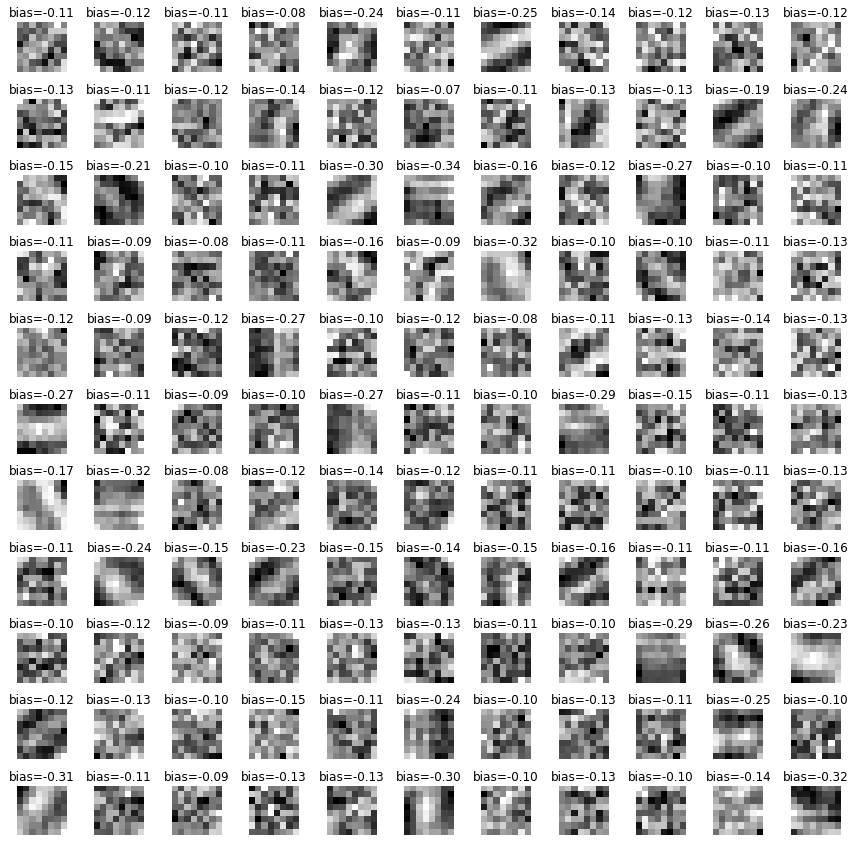

In [71]:
plot_layer_kernels(mnist_model.layers[1])

C:\Users\jwu202\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


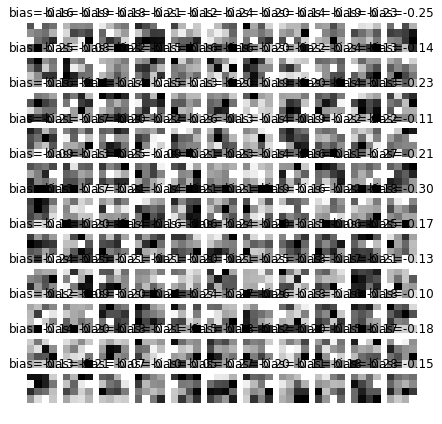

In [91]:
plot_layer_kernels(mnist_model.layers[4])

### Putting in a Generative Network

In [21]:
mnist_model.trainable = False

In [22]:
mnist_model.summary()

W0619 16:55:14.595874 12228 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       65664     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0

In [23]:
digit_aliased_model.trainable = False

In [24]:
digit_aliased_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        24608     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        8208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40970     
Total params: 147,572
Trainable params: 73,786
Non-trainable params: 73,786
____________________________________________

In [25]:
encoder = Sequential([
    digit_aliased_model,
    #layers.Dense(12, use_bias=False),
    #layers.LeakyReLU(),
    #layers.Dropout(0.1),
    #layers.Dense(gridParam1),
    #layers.Dense(gridParam2),
    layers.Dense(gridParam1*gridParam2, activation=tf.nn.sigmoid)
])

In [26]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 10)                73786     
_________________________________________________________________
dense_1 (Dense)              (None, 144)               1584      
Total params: 75,370
Trainable params: 1,584
Non-trainable params: 73,786
_________________________________________________________________


#### Training the Generative Network (Polar Regular Grid)

In [49]:
BATCH_SIZE = 500
BATCHES = BUFFER_SIZE // BATCH_SIZE

In [54]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy()

def encoder_loss(input_digit, output_digit, encoded_images):
    loss = cross_entropy(input_digit, output_digit) + (1 / (BATCH_SIZE * gridSize1 * gridSize2)) * tf.reduce_sum(tf.math.sin(tf.constant(np.pi) * encoded_images))
    return loss

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

In [55]:
display_digits = np.array([i for i in range(10)])
display_digit_images = np.array(list(map(digit_to_image, display_digits)))

In [56]:
image_directory = "./data/training-intermediate-data/training-images/"

In [57]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,3))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(grid.render(np.array(predictions[i, :])), cmap='gray', vmin=-1, vmax=1)
        plt.title(i)
        plt.axis('off')
        
    plt.suptitle(f"Epoch {epoch}")

    plt.savefig(image_directory + 'generated-epoch-{0:02d}.png'.format(epoch))
    plt.show()

In [58]:
@tf.function
def train_step(digits, digit_images, logfile):
    with tf.GradientTape() as enc_tape:
        encodings = encoder(digit_images, training=True)
        encoded_images = tf.map_fn(grid.render_tensor, encodings)
        #print(encoded_images.shape)

        output_digits = mnist_model(encoded_images)
        # expected_digits = digit_aliased_model(digit_images)
        expected_digits = tf.one_hot(digits, 11) # 11 with garbage

        enc_loss = encoder_loss(expected_digits, output_digits, encoded_images)
        #print(enc_loss)

    tf.print(enc_loss, output_stream=logfile)
    
    gradients_of_encoder = enc_tape.gradient(enc_loss, encoder.trainable_variables)
    #print(gradients_of_encoder)

    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))

In [59]:
# checkpoint_dir = './data/training-intermediate-data/training-checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(encoder_optimizer=encoder_optimizer,
#                                  encoder=encoder)

In [60]:
# def find_accuracy(nsamples=1000):
#     global digit_images, digits, mnist_model, encoder, grid
#     correct = sum(np.equal(digits[:nsamples], tf.argmax(mnist_model(tf.map_fn(grid.render_tensor, 
#                                                         encoder(digit_images[:nsamples]))), axis=1)))
#     accuracy = correct / nsamples
#     return accuracy

In [61]:
def train(epochs, logpath):
    
    logfile = "file://" + logpath 
    
    # Fresh log
    open(logpath, 'w').close()
        
    
    for epoch in range(epochs):
        start = time.time()

        for i in range(BATCHES):
            imin = i * BATCH_SIZE
            imax = (i+1) * BATCH_SIZE
            
            digits_slice = digits[imin:imax]
            digit_images_slice = digit_images[imin:imax]
            
            if len(digits_slice) > 0:
                train_step(digits_slice, digit_images_slice, logfile)
            
            #print(f"BATCH {i} DONE")

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(encoder,
                                 epoch + 1,
                                 display_digit_images
                                 )
        
    #     if (epoch + 1) % 2 == 0:
    #         checkpoint.save(file_prefix = checkpoint_prefix)


        #accuracy = find_accuracy()
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(encoder,
                           epochs,
                           display_digit_images)

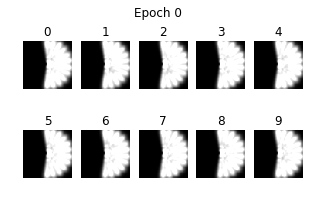

In [62]:
generate_and_save_images(encoder,
                         0,
                         display_digit_images
                         )

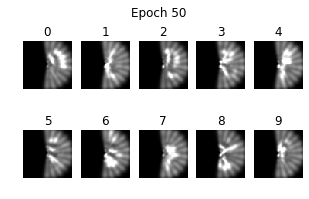

In [63]:
#%%time
EPOCHS = 50
train(EPOCHS, loss_filepath)

In [64]:
def plot_loss(logpath):
    with open(logpath) as infile:
        loss_raw = infile.readlines()

    loss_data = np.array(list(map(float, loss_raw)))

 
    plt.plot(range(loss_data.shape[0]), loss_data)
    plt.ylabel("Categorical Cross Entropy between\nPrediction and One-Hot Class")
    plt.xlabel("Training Batch (each containing 500 images)")
    plt.title("Decoder Loss per Epoch")

    plot_file = logpath.replace("losses", "graphs").replace(".log", ".png")
    plt.savefig(plot_file)
    print("./03-psychophysics/" + plot_file)
    return plot_file

./03-psychophysics/./data/training-intermediate-data/training-graphs/2019-06-19_15-48_loss_PolarGrid_12-12_64-64.png


'./data/training-intermediate-data/training-graphs/2019-06-19_15-48_loss_PolarGrid_12-12_64-64.png'

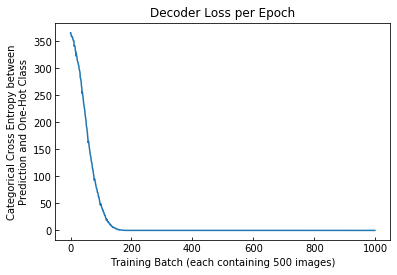

In [65]:
plot_loss(loss_filepath)

In [66]:
generated_images = glob.glob(image_directory + ("*.png"))
images = [PIL.Image.open(image) for image in generated_images]

# save the first image 10 times
images[0].save(gif_filepath,
               save_all=True,
               append_images=[images[0]] * 10 + images + [images[-1]]*10,
               duration=100,
               loop=0)

In [67]:
with open(grid_filepath, 'wb') as outfile:
    pickle.dump(grid, outfile)
encoder.save(encoder_filepath)
# encoder = tf.keras.models.load_model(encoder_filepath)

# Appendix

## Generating Static Digit Images

This script generates static images of centered digits as PNG files.

In [ ]:
from PIL import Image, ImageDraw, ImageFont

baseColour = (0, 0, 0)
baseSizeX, baseSizeY = (16, 16)
textColour = (255, 255, 255)

saveExtension = "png"

for digit in range(10):
    baseImage = Image.new("RGB", (baseSizeY, baseSizeX), baseColour)
    base = ImageDraw.Draw(baseImage)

    text = str(digit)
    textSizeX, textSizeY = base.textsize(text)
    textPosition = (baseSizeX / 2 - textSizeX / 2, baseSizeY / 2 - textSizeY / 2)
    base.text(textPosition, text, textColour)

    saveName = str(digit)
    baseImage.save(f"./data/digit-images/{saveName}.{saveExtension}")

# Blank white
baseImage = Image.new("RGB", (baseSizeY, baseSizeX), (255,255,255))
base = ImageDraw.Draw(baseImage)
baseImage.save(f'./data/digit-images/blank.{saveExtension}')
